<a href="https://colab.research.google.com/github/fantaxiah/DeepLearningSpring23/blob/main/Module3_HW2Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import torch ## we need torch and torchvision
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose ## and we need transform
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])) ## Here we get the data, we can transform the data  to a tensor and normalized the vectors with mean 0.5
              ## and standard deviation 0.5

In [57]:
#Note that pixel values were transformed from the range [0, 1] to the range [-1, 1].
#Look at sample tensor values.
img, label = mnist[2] 
print('Label: ', label)
print(img[:,10:15,10:15]) 
torch.min(img), torch.max(img) #Check the min and max of the images

Label:  4
tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-0.6157, -0.0902,  0.1294,  0.1765,  0.8902]]])


(tensor(-1.), tensor(1.))

In [58]:
img.size()

torch.Size([1, 28, 28])

Label: 4


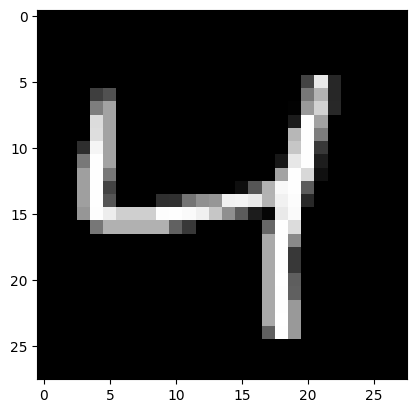

In [59]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)
     
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray') 
print('Label:', label)

In [60]:
#Create a dataloader to load the images in batches.
from torch.utils.data import DataLoader ### We need this and import the DataLoader

batch_size = 20
data_loader = DataLoader(mnist, batch_size, shuffle=True) 

In [61]:
#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

first batch
torch.Size([20, 1, 28, 28])
tensor([9, 7, 5, 5, 2, 2, 6, 4, 0, 1, 5, 6, 3, 6, 0, 2, 2, 1, 3, 4])


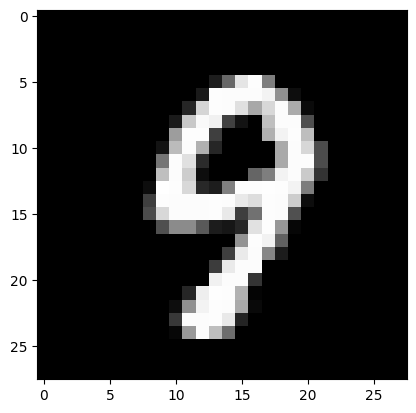

In [62]:
for img_batch, label_batch in data_loader:
    print('first batch') ## Here we could see how the first batch is going to work, with the shape
    print(img_batch.shape) ## The shape
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)  ## we can also print the label of the batch
    break 

In [63]:
#Discriminator Network 
image_size = 784 #28x28=784
hidden_size = 256 #number of hidden nodes

In [64]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2), 
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()) 

In [65]:
#Move the discriminator model to the chosen device.
D.to(device);

In [66]:
#Genarator Network
latent_size = 100

In [67]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size), ## Linear Layer with ReLu activation function, we can make sure that we have -1 or 1
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [68]:
#Move the generator model to the chosen device.
G.to(device);

TRAIN THE MODEL

In [69]:
criterion = nn.BCELoss() #Binary cross entropy function
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002) 

In [114]:
def reset_grad():  
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    #Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device) 
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    #Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels) 
    real_score = outputs

    #Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    #Combine losses
    d_loss = d_loss_real + d_loss_fake
    #Reset gradients
    reset_grad()
    #Compute gradients
    d_loss.backward()
    #Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [106]:
# from pickle import TRUE
# #W-loss
# criterion = nn.MSELoss()
# d_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0002)
# lambda_gp = 10

# def train_discriminator(images):
#     real_outputs = D(images)
#     d_loss_real = criterion(real_outputs) 

#     #Loss for fake images
#     z = torch.randn(batch_size, latent_size).to(device)
#     fake_images = G(z)
#     fake_outputs = D(fake_images)
#     d_loss_fake = criterion(fake_outputs)

#     #Gradient penalty
#     epsilon = torch.rand(batch_size, 1, 1, 1).to(device)
#     x_hat = epsilon * images.data + (1 - epsilon) * fake_images.data
#     x_hat.requires_grad = True
#     hat_outputs = D(x_hat)
#     gradients = torch.autograd.grad(outputs = hat_outputs, inputs = x_hat, grad_outputs = torch.ones(hat_outputs.size()).to(device), create_graph= True)
#     gradient_penalty = lambda_gp * ((gradients.norm(2, dim=1) - 1) ** 2).mean()

#     #Combine losses
#     d_loss = d_loss_real + d_loss_fake + gradient_penalty
#     #Reset gradients
#     reset_grad()
#     #Compute gradients
#     d_loss.backward()
#     #Clip
#     torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm = 0.01)
#     #Adjust the parameters using backprop
#     d_optimizer.step()
    
#     return d_loss, real_outputs, fake_outputs

In [123]:
#Change loss function for generator
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def train_generator():
    #Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z) 
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)
    fake_outputs = D(fake_images)

    #Backprop and optimize
    g_optimizer.zero_grad()
    g_loss.backward() 
    g_optimizer.step()
    return g_loss, fake_images

In [73]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

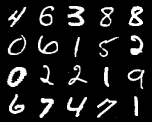

In [74]:
from IPython.display import Image
from torchvision.utils import save_image

for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=5)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

torch.Size([20, 1, 28, 28])
tensor([9, 6, 5, 7, 8, 8, 1, 0, 6, 2, 4, 0, 7, 6, 4, 1, 0, 2, 1, 7])


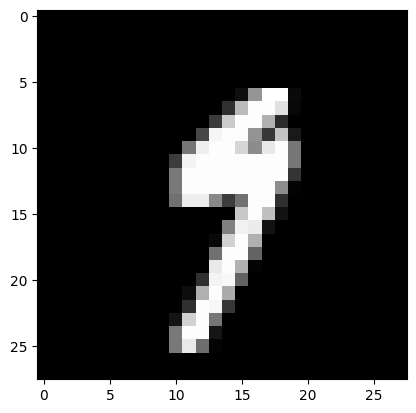

In [75]:
for img_batch, label_batch in data_loader:
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

Saving fake_images-0000.png


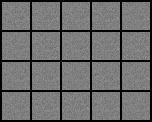

In [76]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=5)
    
#Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [124]:
num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], [] #d_loss, g_loss, real_score, fake_score

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        #Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        #Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images) 
        g_loss, fake_images = train_generator()
        
        #Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item()) ## The real score values
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    #Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/3000], d_loss: 0.0044, g_loss: 0.9343, D(x): 1.00, D(G(z)): 0.07
Epoch [0/300], Step [400/3000], d_loss: 0.0079, g_loss: 0.9592, D(x): 0.99, D(G(z)): 0.09
Epoch [0/300], Step [600/3000], d_loss: 0.0000, g_loss: 1.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [0/300], Step [800/3000], d_loss: 0.0000, g_loss: 0.9993, D(x): 1.00, D(G(z)): 0.00
Epoch [0/300], Step [1000/3000], d_loss: 0.0000, g_loss: 1.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [0/300], Step [1200/3000], d_loss: 0.0000, g_loss: 1.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [0/300], Step [1400/3000], d_loss: 0.0000, g_loss: 1.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [0/300], Step [1600/3000], d_loss: 0.0000, g_loss: 1.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [0/300], Step [1800/3000], d_loss: 0.0000, g_loss: 1.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [0/300], Step [2000/3000], d_loss: 0.0000, g_loss: 1.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [0/300], Step [2200/3000], d_loss: 0.0000, g_loss: 1.0000, D(x): 1.00, D(G(z)): 0.00
Epo

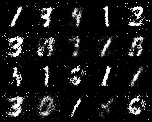

In [125]:
Image('./samples/fake_images-0010.png')

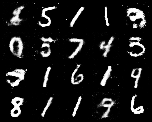

In [126]:
Image('./samples/fake_images-0050.png')

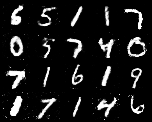

In [127]:
Image('./samples/fake_images-0090.png')

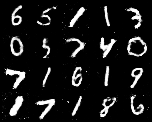

In [128]:
Image('./samples/fake_images-0130.png')

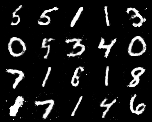

In [129]:
Image('./samples/fake_images-0170.png')

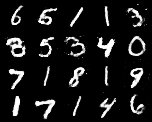

In [130]:
Image('./samples/fake_images-0210.png')

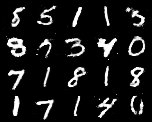

In [131]:
Image('./samples/fake_images-0250.png')

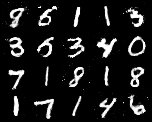

In [132]:
Image('./samples/fake_images-0290.png')

Text(0.5, 1.0, 'Losses')

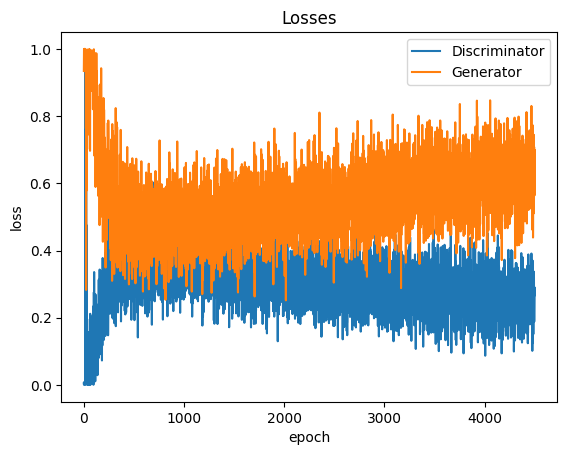

In [133]:
plt.plot(d_losses, '-') #discriminator loss
plt.plot(g_losses, '-') #generator loss
plt.xlabel('epoch') #define the axis x, epochs
plt.ylabel('loss') #define the label y, loss
plt.legend(['Discriminator', 'Generator']) 
plt.title('Losses') 